In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

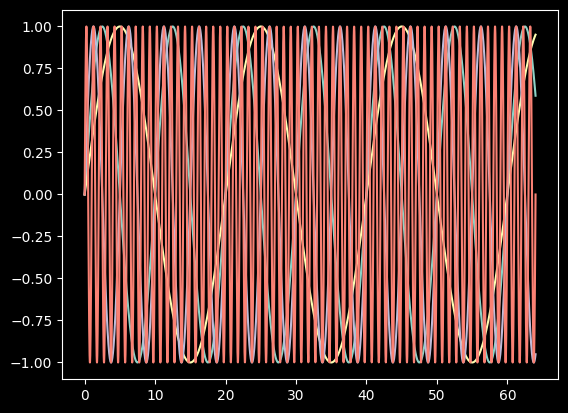

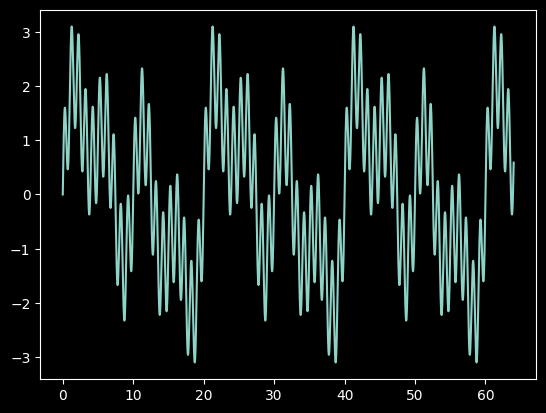

In [3]:
t_s = 64
sample_rate_per_s = 64
total_points = t_s*sample_rate_per_s
x = np.linspace(0, t_s, total_points)
gen_sin = lambda bps, x: np.sin(2*np.pi*bps*x)
pure_waves = [
	gen_sin(1/10, x), # 1 period every 10 seconds
	gen_sin(1/20, x), # 1 period over the 20 seconds
	gen_sin(1/5, x), # 1 period every 5 seconds
	gen_sin(1, x), # 1 hz
]
for p in pure_waves:
	plt.plot(x, p)
wave = np.vstack(pure_waves).sum(0)
plt.show()
plt.plot(x, wave)

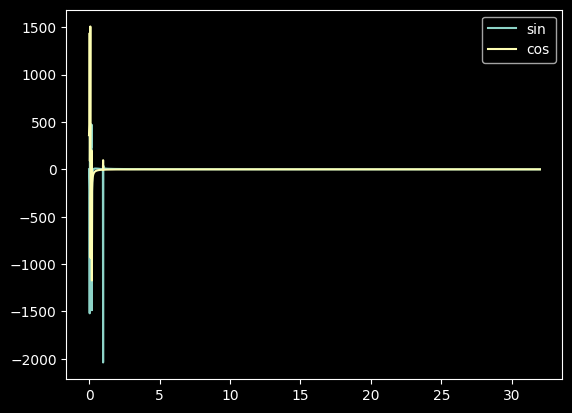

In [4]:
def plot_freq_space(f, frequency_space):
    plt.plot(f, np.imag(frequency_space), label="sin")
    plt.plot(f, np.real(frequency_space), label="cos")
    plt.legend()
	
def dft_better(y):
    # generate possible frequencies 
    # So the smallest frequency is 1/t_s which is 1/20 hz in this case. The largest frequency is  
    N = len(y)
    x = np.arange(N)
    f = np.arange(N) 

    # weighted sum over frequencies to transform time space to frequency space
    frequency_space = np.zeros(len(f), dtype=np.complex128)
    for i in range(len(f)):
        pure_wave = np.exp(-1j*f[i]*2*np.pi*x/N)
        frequency_space[i] += pure_wave.dot(y)

    return frequency_space

def dftfreq(N, d):
    return np.arange(0, N*d, d) # [0, max_freq]
    

N = len(wave)
dft_result = dft_better(wave)
freqs = dftfreq(N, d=1/sample_rate_per_s)

freqs = freqs[:N//2]
dft_result = dft_result[:N//2]

plot_freq_space(freqs, dft_result)

How can I use less computations? The answer is to look at where the frequencies overlap. This way I only have to do the $\log_2 N$ multiplies with the curve and my data points. I still have to sum over $N$ times though.

Let's see the overlaps by visualizing them

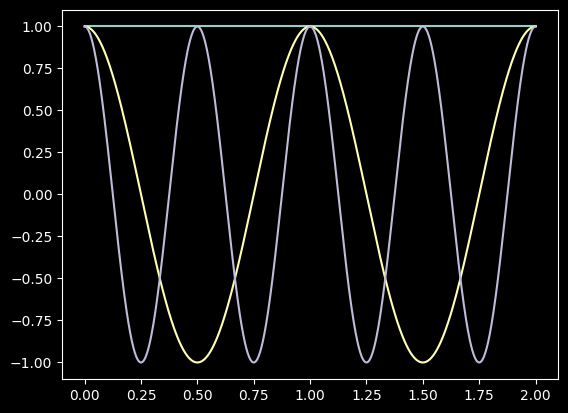

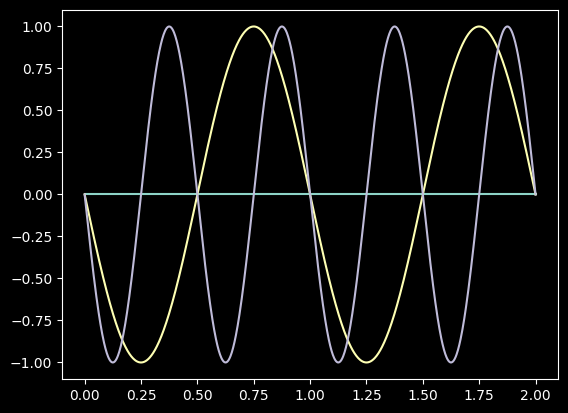

In [5]:
x = np.linspace(0, 2, 1000)
N = len(x)
freqs = np.arange(3)

res = []
for f in freqs:
	pure_wave = np.exp(-1j * f * 2*np.pi * x)
	res.append(pure_wave)

for r in res:
	plt.plot(x, np.real(r))

plt.show()

for r in res:
	plt.plot(x, np.imag(r))

freqs [0 1 2 3]
even [0 2]
odd [1 3]


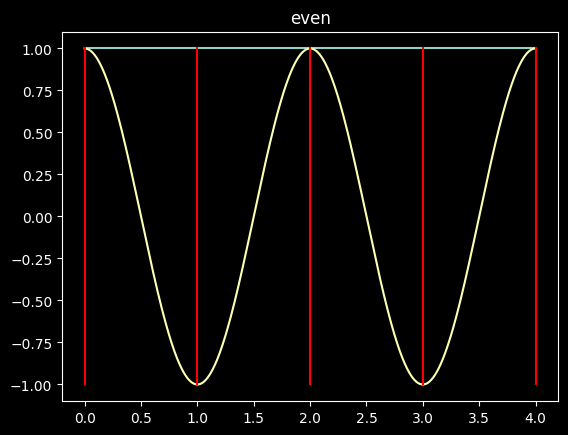

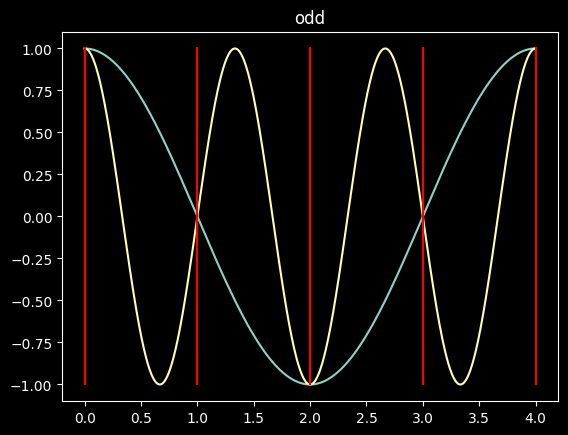

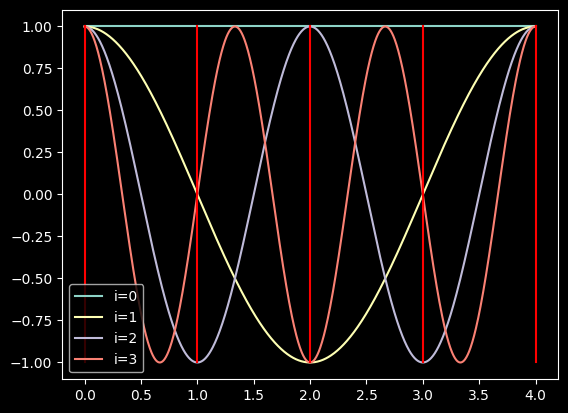

In [6]:
N = 4
x = np.linspace(0, N, 1000)
freqs = np.arange(N)
even_freqs = freqs[freqs % 2 == 0]
odd_freqs = freqs[freqs % 2 != 0]

print("freqs", freqs)
print("even", even_freqs)
print("odd", odd_freqs)

even_res = []
for f in even_freqs:
	pure_wave = np.exp(-1j * f * 2*np.pi * x / N)
	even_res.append(pure_wave)

odd_res = []
for f in odd_freqs:
	pure_wave = np.exp(-1j * f * 2*np.pi * x / N)
	odd_res.append(pure_wave)

res = []
for f in freqs:
	pure_wave = np.exp(-1j * f * 2*np.pi * x / N)
	res.append(pure_wave)

plt.title("even")
for i, r in enumerate(even_res):
	plt.plot(x, np.real(r))
for i in range(N+1):
	plt.plot([i, i], [-1, 1], c="r")

plt.show()

plt.title("odd")
for i, r in enumerate(odd_res):
	plt.plot(x, np.real(r))
for i in range(N+1):
	plt.plot([i, i], [-1, 1], c="r")

plt.show()
for i, r in enumerate(res):
	plt.plot(x, np.real(r), label=f"i={i}")
for i in range(N+1):
	plt.plot([i, i], [-1, 1], c="r")
plt.legend()


The observation is that if I split the even and odd number frequencies, 
for the odd, I notice that have the values overlap, but half do not overlap. Which means I can compute all, and I just get the other for free. That is a 1/2 saving. And if I somehow call this recursively, you could imagine, I keep only having to compute half.

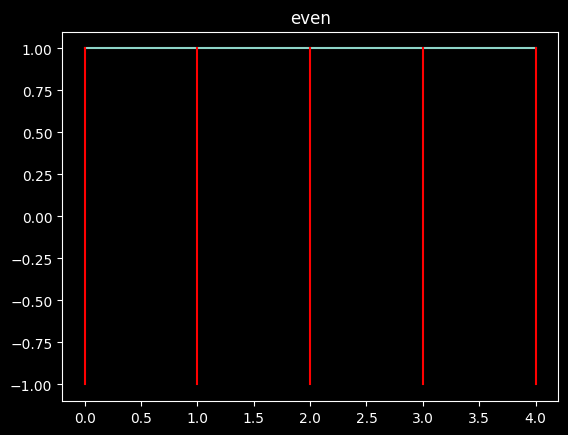

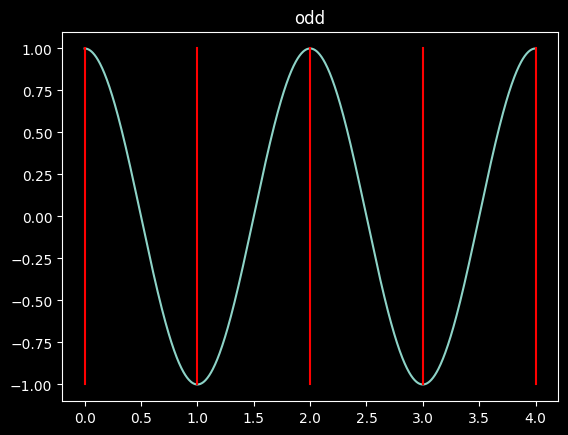

In [7]:
N = 4
even_freqs2 = [even_freqs[0]]
odd_freqs2 = [even_freqs[1]]

even_res = []
for f in even_freqs2:
	pure_wave = np.exp(-1j * f * 2*np.pi * x / N)
	even_res.append(pure_wave)

odd_res = []
for f in odd_freqs2:
	pure_wave = np.exp(-1j * f * 2*np.pi * x / N)
	odd_res.append(pure_wave)

plt.title("even")
for i, r in enumerate(even_res):
	plt.plot(x, np.real(r))
for i in range(N+1):
	plt.plot([i, i], [-1, 1], c="r")

plt.show()

plt.title("odd")
for i, r in enumerate(odd_res):
	plt.plot(x, np.real(r))
for i in range(N+1):
	plt.plot([i, i], [-1, 1], c="r")


The issue is I just don't completely understand which data points overlap, let me also plot the data points.

/usr/local/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


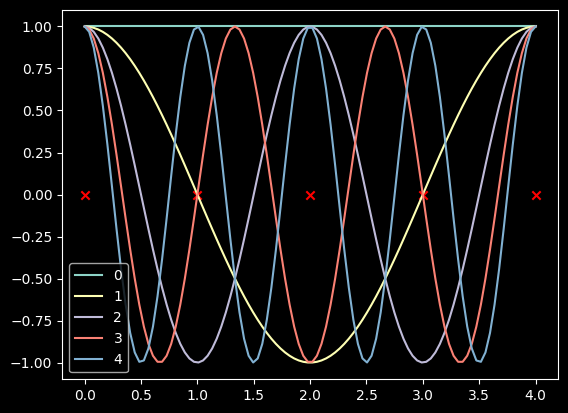

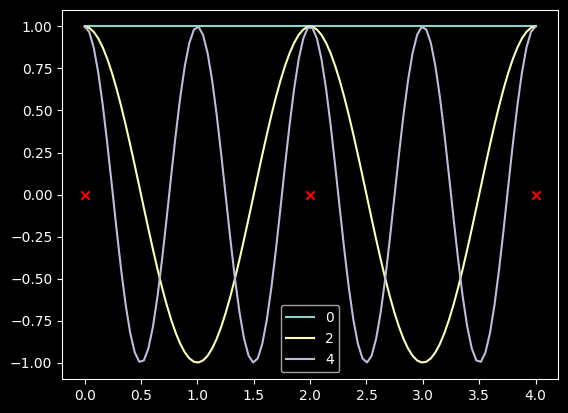

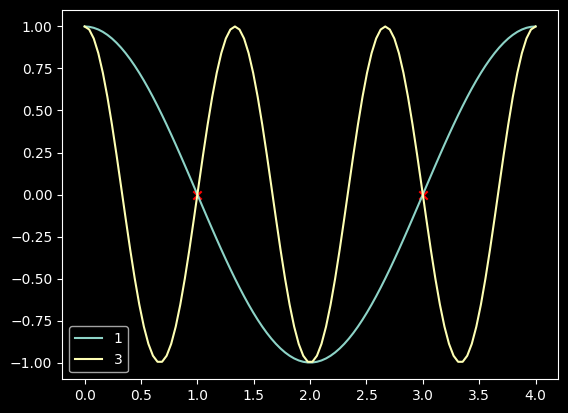

In [8]:
N = 4
x = np.arange(N+1)
y = np.sin(x*2*np.pi)

xvis = np.linspace(0, N, 100) # just to visualize curves

for i, f in enumerate(range(N+1)):
	plt.plot(xvis, np.exp(-1j*f*xvis*2*np.pi / N), label=f"{i}")
	plt.scatter([x[i]],[0], c="red", marker="x")
plt.legend()

plt.show()
for i, f in enumerate(range(N+1)):
	if i % 2 == 0:
		plt.plot(xvis, np.exp(-1j*f*xvis*2*np.pi / N), label=f"{i}")
		plt.scatter([x[i]],[0], c="red", marker="x")
plt.legend()

plt.show()

for i, f in enumerate(range(N+1)):
	if i % 2 != 0:
		plt.plot(xvis, np.exp(-1j*f*xvis*2*np.pi / N), label=f"{i}")
		plt.scatter([x[i]],[0], c="red", marker="x")
plt.legend()

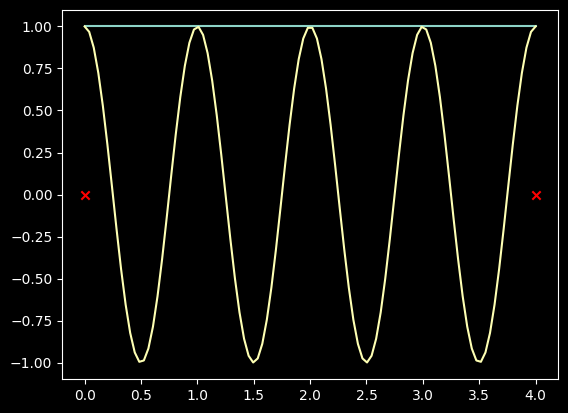

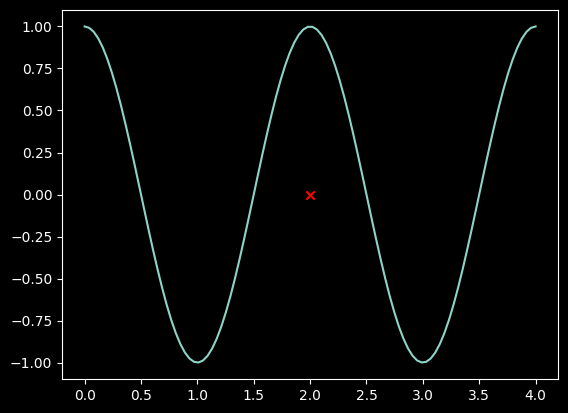

In [9]:
x = [0,2,4]
for i, f in enumerate([0,2,4]):
	if i % 2 == 0:
		plt.plot(xvis, np.exp(-1j*f*xvis*2*np.pi / N), label=f"{i}")
		plt.scatter([x[i]],[0], c="red", marker="x")

plt.show()
for i, f in enumerate([0,2,4]):
	if i % 2 != 0:
		plt.plot(xvis, np.exp(-1j*f*xvis*2*np.pi / N), label=f"{i}")
		plt.scatter([x[i]],[0], c="red", marker="x")

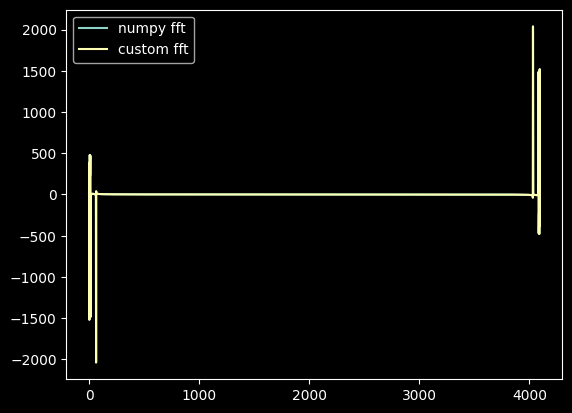

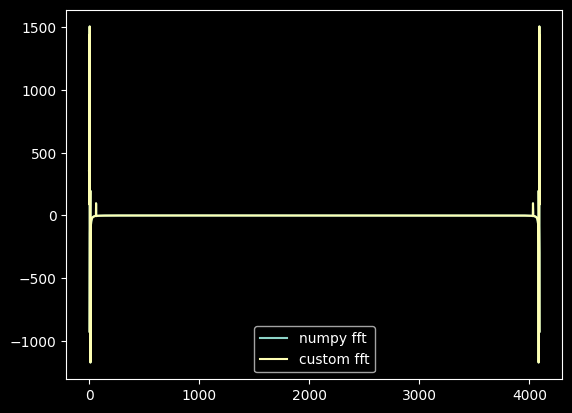

In [22]:
def fft(x):
	N = len(x)
	if N <= 1: return x
	even, odd = fft(x[0::2]), fft(x[1::2])
	T = np.exp(-2j*np.pi*np.arange(N//2)/N)*odd
	return np.concatenate((even+T, even-T))

plt.plot(np.imag(np.fft.fft(wave)), label='numpy fft')
plt.plot(np.imag(fft(wave)), label='custom fft')
plt.legend()
plt.show()

plt.plot(np.real(np.fft.fft(wave)), label='numpy fft')
plt.plot(np.real(fft(wave)), label='custom fft')
plt.legend()
plt.show()
